# Homework 5 Coding: Transport Modeling

For this coding assignment, you will write functions to calculate molar flux (and sometimes current density) for several given applications.  I will do much of the coding for you, at first, but then let you handle more and more of it, as we move along.

## Part I: Gas-phase diffusion in a PEMFC cathode.

For this scenario, we will model gas-phase transport in the gas diffusion layer (GDL) of a PEMFC cathode.

The cathode is 100 microns thick, with a porosity (gas-phase volume fraction) of 57%, with the tortuosity factor modeled using a Bruggeman coefficient of $n = -0.5$.

Use the Cozeny-Karman relationship to estimate the cathode GDL permeability, with a carbon particle diameter of 0.5 microns, and an average pore radius of 2 microns.

We will simulate transport at 60 C, where the dynamic viscosity of moist air is $\mu = 2.08\times 10^{-5}\,\frac{\rm kg}{\rm m-s}$.  The conditions at the two nodes are:

1. Node 1: in the gas flow channel
- Pressure = 1 atmosphere
- $X_{\rm O_2} = 0.21$
- $X_{\rm N_2} = 0.79$
- $X_{\rm H_2O} = 0.0$

2. Node 2: in the catalyst layer, where O$_2$ is consumed and H$_2$O is produced:
- Pressure = 100 kPa
- $X_{\rm O_2} = 0.16$
- $X_{\rm N_2} = 0.80$
- $X_{\rm H_2O} = 0.04$

The gas-phase species diffusion coefficients are:
- O$_2$: $2.438\times 10^{-5}\,\frac{\rm m^2}{\rm s}$
- N$_2$: $2.798\times 10^{-5}\,\frac{\rm m^2}{\rm s}$
- H$_2$O: $1.9\times 10^{-5}\,\frac{\rm m^2}{\rm s}$

In [183]:
import numpy as np

dY = 100e-6 # m
eps_g = 0.57
n_Brugg = -0.5

d_part = 0.5e-6
r_p = 2e-6

T = 333.15 # K
P_1 = 101325 # Pa
P_2 = 100000 # Pa

R = 8.3145 # J/mol-K
F = 96485  # C/mol equiv

# Species order: O2, N2, H2O_v
X_k_1 = np.array([0.21, 0.79, 0.0])
X_k_2 = np.array([0.16, 0.80, 0.04])

mu = 2.08e-5 #kg/m-s

D_k = np.array([2.438e-5, 2.798e-5, 1.9e-5]) #m2/s

### We are going to load all parameters into a series of Python dictionaries

We will pass these dictionaries to our function.  The dictionaries just make it more efficient then having 12 different input variables.

In [184]:
# State variables for node 1:
state1 = {'X_k':X_k_1, 'P':P_1, 'T':T}
# State variables for node 2:
state2 = {'X_k':X_k_2, 'P':P_2, 'T':T}

# Geometric and microstructure parameters:
geom = {'eps_g':eps_g, 'n_Brugg':n_Brugg, 'd_part':d_part, 'dY':dY}
# Gas properties
gas_props = {'D_k':D_k, 'mu':mu}

### Example for using values stored in dictionaries:

In [185]:
# To access a dictionary value:
print(gas_props['mu'])
print(state1['X_k'])
X_sum = sum(state1['X_k'])
print('The mole fractions sum to',X_sum)

2.08e-05
[0.21 0.79 0.  ]
The mole fractions sum to 1.0


## YOUR CODE GOES HERE:

Create a function that calculates the species fluxes, given our input dictionaries.

The function must return an array `N_k` that provides the species molar fluxes in mol/m$^2$-s. 

In [186]:
def pemfc_gas_transport(state1, state2, geom, gas_props):
    N_k = np.zeros_like(state1['X_k'])
    dY = geom['dY']/2 #distance between nodes
    # Interface properties
    C_1 = state1['P']/(R*state1['T'])
    C_2 = state2['P']/(R*state2['T'])
    print('C_1',C_1)
    print('C_2',C_2)
    C_k_1 = state1['X_k']*C_1
    C_k_2 = state2['X_k']*C_2
    print('C_k_1',C_k_1)
    print('C_k_2',C_k_2)
    C_k_intf = (C_k_1 + C_k_2)*0.5 
    print('C_k_intf',C_k_intf)
    #P_intf = (state1['P'] + state2['P'])/2
    #print('P_intf',P_intf)
    X_k_intf = (state1['X_k'] + state2['X_k'])*0.5
    #print('X_k_intf',X_k_intf)
    #C_k_intf_old = X_k_intf*(P_intf/(R*state1['T']))
    #print('C_k_intf_old',C_k_intf_old)
    gradP = (state2['P'] - state1['P'])/dY
    gradX = (state2['X_k'] - state1['X_k'])/dY
    #print('gradP',gradP)
    #print('gradX',gradX)
    tau_fac = geom['eps_g']**geom['n_Brugg']
    D_eff_k = gas_props['D_k']*(geom['eps_g']/tau_fac)
    #K_g = (geom['eps_g']**3 * geom['d_part']**2)/(72*tau_fac*(1-geom['eps_g'])**2)
    K_g = (geom['eps_g']**3 * geom['d_part']**2)/(72.0 * tau_fac**2 * (1-geom['eps_g'])**2)
    #print('tau_fac',tau_fac)
    #print('D_eff_k',D_eff_k)
    #print('K_g',K_g)
    vel_diff_k = -D_eff_k * gradX / X_k_intf
    vel_conv = -K_g * gradP / gas_props['mu']
    vel_k = vel_diff_k + vel_conv
    #print('vel_diff_k',vel_diff_k)
    #print('vel_conv',vel_conv)
    #print('vel_k',vel_k)
    N_k = C_k_intf*X_k_intf*vel_k
    print('N_k',N_k)
    #N_k_diff = C_k_intf*X_k_intf*vel_diff_k
    #MW_k = np.array([32, 28, 18])
    #J_k_diff = MW_k*N_k_diff
    #J_k_diff_sum = sum(J_k_diff)
    #print('Sum of J_k_diff = ',J_k_diff_sum)
    #J_k_diff = -D_eff_k*gradX
    #J_k_diff_sum = sum(J_k_diff)
    #print('no vel, Sum of J_k_diff = ',J_k_diff_sum)
    #J_k_diff = -D_eff_k*gradX*MW_k
    #J_k_diff_sum = sum(J_k_diff)
    #print('no vel *MW, Sum of J_k_diff = ',J_k_diff_sum)
    #J_k_diff = -D_eff_k*gradX/MW_k
    #J_k_diff_sum = sum(J_k_diff)
    #print('no vel /MW, Sum of J_k_diff = ',J_k_diff_sum)
    return N_k
    

### Now calculate the fluxes between nodes 1 and 2 (you do not need to do anything; just run the cell)
### Then check your answers against mine:

C_1 36.57974361092539
C_2 36.10140006012868
C_k_1 [ 7.68174616 28.89799745  0.        ]
C_k_2 [ 5.77622401 28.88112005  1.444056  ]
C_k_intf [ 6.72898508 28.88955875  0.722028  ]
N_k [ 0.07374245 -0.01156707 -0.00468644]


Text(0.5, 0, 'Species')

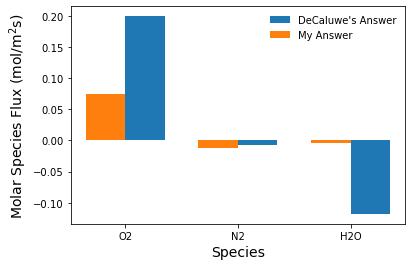

In [187]:
N_k_calc = pemfc_gas_transport(state1, state2, geom, gas_props)

from matplotlib import pyplot as plt
width = 0.35
N_k_check = np.array([0.19913, -0.007275, -0.11794]) #mol/m2/s

fig, ax = plt.subplots()

labels = ['O2', 'N2', 'H2O']
x = np.arange(len(labels))

ax.bar(x+width/2,N_k_check,width)
ax.bar(x-width/2,N_k_calc,width)
ax.legend(['DeCaluwe\'s Answer','My Answer'],frameon=False)

ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.set_ylabel('Molar Species Flux (mol/m$^2$s)',fontsize=14)
ax.set_xlabel('Species',fontsize=14)

## Part II: Charged species transport in a liquid electrolyte:

Next we will calculate molar fluxes for a liquid electrolyte in a battery anode.  These calculations will be for electro-diffusion only - there is no convection!

The molar density of the electrolyte is assumed constant at 1100 moles per m$^3$

The temperature is 45$^\circ$C.

The electrolyte is LiPF$_6$, dissolved in a generic "solvent" molecule, with the following conditions:

1. Node 1:
- $X_{\rm Li^+} = 0.03$
- $X_{\rm PF^-_6} = 0.03$
- $X_{\rm Solvent} = 0.94$
- Electric potential $\phi_1 = 0.9$ V

2. Node 2:
- $X_{\rm Li^+} = 0.06$
- $X_{\rm PF^-_6} = 0.06$
- $X_{\rm Solvent} = 0.88$
- Electric potential $\phi_2 = 0.5$ V

The distance between the nodes is 30 microns, and the average diameter of the solid active material particles is 5 microns.  The anode porosity (electrolyte volume fraction) is 23%, and the tortuosity is characterized by a Bruggeman coefficient of -0.5.

In [188]:
C_elyte = 1100 #mol/m3

# Species order: Li+, PF6-, solvent
X_k_1 = np.array([0.03, 0.03, 0.94])
X_k_2 = np.array([0.06, 0.06, 0.88])

z_k = np.array([1., -1., 0.])

T = 318.  #K

dY = 30e-6

D_k = np.array([1.52e-10, 0.25e-10, 1e-12])

phi_1 = 0.9
phi_2 = 0.5

d_part = 5e-6

eps_elyte = 0.23
n_brugg = -0.5

## ENTER CODE HERE 

### to Create the Necessary Dictionaries. We will call the states just 's1' and 's2', this time:

In [189]:
s1 = {'X_k':X_k_1, 'phi':phi_1, 'T':T}
s2 = {'X_k':X_k_2, 'phi':phi_2, 'T':T}

geom = {'eps_elyte':eps_elyte, 'n_Brugg':n_Brugg, 'd_part':d_part, 'dY':dY }
elyte_pars = {'D_k':D_k, 'C':C_elyte, 'z_k':z_k}

## NOW CREATE YOUR FLUX-CALCULATING FUNCTION:

In [190]:
def electrolyte_transport(state1, state2, geom, elyte_pars):
    tau_frac_elyte = geom['eps_elyte']**geom['n_Brugg']
    gradC_k = elyte_pars['C']*(state2['X_k'] - state1['X_k'])/geom['dY']
    gradphi = (state2['phi'] - state1['phi'])/geom['dY']
    
    C_k_intf = elyte_pars['C']*state1['X_k'] + gradC_k*(geom['dY']/2)
    D_k_eff = elyte_pars['D_k']*geom['eps_elyte']/tau_frac_elyte
    
    
    N_k = -D_k_eff*gradC_k - D_k_eff*C_k_intf*elyte_pars['z_k']*F*gradphi/(R*state1['T']) #
    return N_k

Now we loop over a range of Node 2 electric potentials.  We use the fluxes to calculate the current density:
\begin{equation}
i = F\sum_k z_kN_k
\end{equation}

In [191]:
dPhi = np.linspace(0,1.1,25)
currents = np.zeros_like(dPhi)
N_k = np.zeros((len(dPhi), len(z_k)))

for j, phi in enumerate(dPhi):
    s2['phi'] = phi #This isn't really the deltaPhi between nodes
    N_k[j,:] = electrolyte_transport(s1,s2, geom, elyte_pars)
    currents[j] = np.dot(z_k,N_k[j,:])*F


## Plot the currents and check them against mine.

### For what potential is the current equal to zero?

Zero current at dPhi =  0.8868918122866205


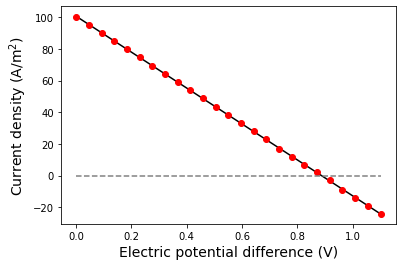

In [192]:
current_check = np.array([100.,  95.,  90.,  85.,  80.,  75.,  69.,
                          64.,  59.,  54.,  49.,  43.,  38.,  33.,
                          28.,  23.,  17.,  12.,   7.,   2.,  -3.,
                          -9.,    -14., -19., -24.])

plt.plot(dPhi, currents, 'k')
plt.plot(dPhi, current_check, 'ro', markerfacecolor=None)
plt.plot(dPhi, np.zeros_like(dPhi),'--',color='0.5')
plt.xlabel('Electric potential difference (V)',fontsize=14)
plt.ylabel('Current density (A/m$^2$)',fontsize=14)

zero=np.interp(0, np.flip(currents), np.flip(dPhi))
print('Zero current at dPhi = ',zero)


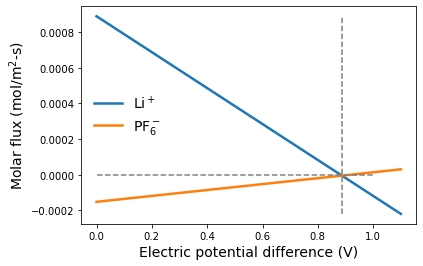

In [193]:

plt.plot(dPhi, N_k[:,0],linewidth=2.5)
plt.plot(dPhi, N_k[:,1],linewidth=2.5)

plt.xlabel('Electric potential difference (V)',fontsize=14)
plt.ylabel('Molar flux (mol/m$^2$-s)',fontsize=14)
plt.legend(['Li$^+$','PF$_6^-$'],frameon=False,fontsize=14)
plt.plot([zero,zero],[N_k[-1,0],N_k[0,0]],'--',color='0.5')
plt.plot([0,1],[0,0],'--',color='0.5')

## Discuss the plot above in this Markdown block.  When is zero ionic current achieved?
Ionic current is zero when $\Delta \phi$ = 0.887 V. As seen in the second plot, this is when the molar flux of each species is 0. This is the potential at which the driving force from the concentration gradient is equal and opposite to the driving force from electrical potential.

$\Delta \phi$ = 0.887 V is labeled wrong. This is actually when $\phi_2$ = 0.887 V. Therefore, $\Delta \phi$ = -0.013 V.




### Now predict current as a function of electrolyte volume fraction $\varepsilon_{\rm elyte}$

Text(0, 0.5, 'Current Density (A/m$^2$)')

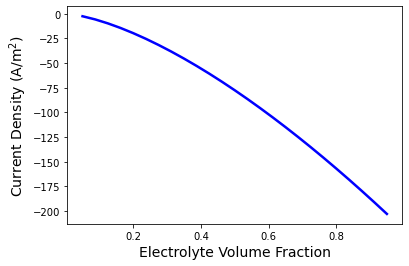

In [194]:
eps_array = np.linspace(0.05,0.95,25)

currents = np.zeros_like(eps_array)
for j, eps in enumerate(eps_array):
    geom['eps_elyte'] = eps
    N_k = electrolyte_transport(s1, s2, geom, elyte_pars)
    currents[j] = np.dot(elyte_pars['z_k'],N_k)*F
    
plt.plot(eps_array, currents,'b',linewidth=2.5)
plt.xlabel('Electrolyte Volume Fraction', fontsize=14)
plt.ylabel('Current Density (A/m$^2$)',fontsize=14)

### Discuss the results.  If you were designing a high-performance anode, what $\varepsilon_{\rm elyte}$ value would you pick?  Why?
If I wanted the Li$^+$ to always be present for the electrodes to consume, (diffusive effects in electrolyte go to zero) then I would choose a large electrolyte volume fraction. This would essentially make the anode more porous, allowing for a smaller tortuosity.

## Part III. Charged defects in a proton-conducting ceramic:

The protonic ceramic membrane in this section has a fixed crystal lattice that can be occupied by one of three species:

- An oxygen atom, O$^\times$ (this is considered the neutral species)
- A vacancy,V$_{\rm O}^{\bullet\bullet}$ which has a charge of +2, relative to the oxygen
- An oxygen atom with a proton attached, OH$^\bullet$

The lattice site concentration is assumed fixed at 22,325 mol per m$^3$.

The vacancy and proton are considered mobile, while the oxide is considered fixed.  We will simulate transport at 600$^\circ$C, where the diffusion coefficients are:

- $D_{\rm V_{\rm O}^{\bullet\bullet}} = 1.28\times 10^{-12}\,\frac{\rm m^2}{\rm s}$
- $D_{\rm O^\times} = 0.0\,\frac{\rm m^2}{\rm s}$
- $D_{\rm OH^\bullet} = 7.46\times 10^{-11}\,\frac{\rm m^2}{\rm s}$

The membrane also has a small amount of electronic conductivity, $\sigma_{\rm el} = 0.001\,\frac{\rm S}{\rm m}$.

We will simulate transport between two nodes, which are 20 microns apart.  The conditions are:

1. Node 1:
- $X_{\rm V_{\rm O}^{\bullet\bullet}} = 0.336$
- $X_{\rm O^\times} = 0.627$
- $X_{\rm OH^\bullet} = 0.037$
- $\phi_1 = 1.1$

2. Node 2:
- $X_{\rm V_{\rm O}^{\bullet\bullet}} = 0.018$
- $X_{\rm O^\times} = 0.938$
- $X_{\rm OH^\bullet} = 0.044$
- $\phi_2 = 0.0$

## Enter the data, here:

In [195]:
C_lattice = 22325 #mol/m3

# Species order: V_O^2+, o^X, OH^1+
X_k_1 = np.array([0.336, 0.627, 0.037])
X_k_2 = np.array([0.018, 0.938, 0.044])

z_k = np.array([2., 0., 1.])

T = 873.15  #K

dY = 20e-6

D_k = np.array([1.28e-12, 0.0, 7.46e-11])

phi_1 = 1.1
phi_2 = 0.0

#Define Dictionaries
s1 = {'X_k':X_k_1, 'phi':phi_1, 'T':T}
s2 = {'X_k':X_k_2, 'phi':phi_2, 'T':T}

geom = {'dY':dY}
ceramic_pars = {'D_k':D_k, 'C':C_lattice, 'z_k':z_k, 'sigma':0.001}

## CREATE YOUR TRANSPORT FUNCTION HERE.

This function should return the fluxes, N_k, and the total current (ionic + electronic).

In [196]:
def protonic_transport(state1, state2, geom, ceramic_pars):
    
    gradC_k = ceramic_pars['C']*(state2['X_k'] - state1['X_k'])/geom['dY']
    gradphi = (state2['phi'] - state1['phi'])/geom['dY']
    
    C_k_intf = ceramic_pars['C']*state1['X_k'] + gradC_k*(geom['dY']/2)    
    
    N_k = -ceramic_pars['D_k']*gradC_k - ceramic_pars['D_k']*C_k_intf*ceramic_pars['z_k']*F*gradphi/(R*state1['T'])    
    
    i_io = np.dot(ceramic_pars['z_k'],N_k)*F 
    i_el = -gradphi*ceramic_pars['sigma']
    
    current = i_io + i_el
    return N_k, current

## Here, we loop over a range of electric potential diffrerences between node 1 and node 2.

We will plot both the total current and the Faradaic efficiency, as a function of $\Delta \phi$.  

The Faradaic efficiency $\eta_{\rm Far}$ refers to the fact that the electronic leakage current is "undesired," for the protonic fuel cell.  We want all current to move ions across the membrane.  Therefore we find the efficiency as:
\begin{equation}
    \eta_{\rm Far} = \frac{i_{\rm ion}}{i_{\rm total}}
\end{equation}

(99.0, 100.0)

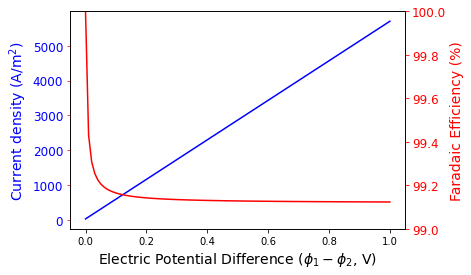

In [197]:
dPhi = np.linspace(0.0, 1.0, 100)
eta_Far = np.zeros_like(dPhi)
i_tot = np.zeros_like(dPhi)

for j, deltaPhi in enumerate(dPhi):
    s2['phi'] = s1['phi']-deltaPhi
    Nk, i_tot[j] = protonic_transport(s1, s2, geom, ceramic_pars)
    i_ion = np.dot(Nk,ceramic_pars['z_k'])*F
    eta_Far[j] = 100*i_ion/i_tot[j]    
    
# Plot the results:
fig, ax = plt.subplots()
plt.plot(dPhi, i_tot,color='b')

# Create a 2nd y axis:
ax2 = ax.twinx()
ax2.plot(dPhi, eta_Far,'r')

# Formatting:
ax.set_xlabel('Electric Potential Difference ($\phi_1 - \phi_2$, V)', fontsize=14)

ax.tick_params(axis='y',color='r',labelcolor='b',labelsize=12)
ax.set_ylabel('Current density (A/m$^2$)',color='b',fontsize=14)
ax.tick_params(axis='y',color='r',labelcolor='b',labelsize=12)

ax2.set_ylabel('Faradaic Efficiency (%)',color='r',fontsize=14)
ax2.tick_params(axis='y',color='r',labelcolor='r',labelsize=12)
ax2.tick_params(axis='y',color='r',labelcolor='r',labelsize=12)
ax2.set_ylim((99,100))

## In this markdown cell, discuss the plot.  What explains the trends?

To check your answers, your total current should go from roughly zero at $\Delta\phi = 0$, to nearly 6000 A/m$^2$ at $\Delta\phi = 1.0.$ Over the same range, the Faradaic efficiency should go from 100% to roughly 99.1%.

At $\Delta\phi = 0$, there is no electronic current leaving only ionic current from a concentration gradient leading to the 100% efficiency. At larger potential differences, additional voltage difference does not change the ratio of ionic current to total current. At this point, concentration gradient between the two nodes has less of an effect on how the species diffuses throughout the solid. 

### Now loop over a smaller range of potentials, to see where we get a net current of zero.

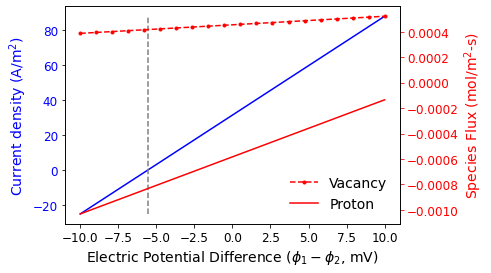

In [198]:
dPhi = np.linspace(-0.01, 0.01, 20)
N_k = np.zeros((len(dPhi),len(state1['X_k'])))
i_tot = np.zeros_like(dPhi)

for j, deltaPhi in enumerate(dPhi):
    s2['phi'] = s1['phi']-deltaPhi
    N_k[j,:], i_tot[j] = protonic_transport(s1, s2, geom, ceramic_pars)

fig, ax = plt.subplots()
plt.plot(1000*dPhi, i_tot,color='b')

zero = 1000*np.interp(0,i_tot,dPhi)
plt.plot([zero,zero],[i_tot[0],i_tot[-1]],'--',color='0.5')

ax.set_ylabel('Current density (A/m$^2$)',color='b',fontsize=14)
ax.tick_params(axis='y',color='k',labelcolor='b',labelsize=12)
ax.tick_params(axis='y',color='k',labelcolor='b',labelsize=12)

ax.tick_params(axis='x',color='k',labelcolor='k',labelsize=12)
ax.set_xlabel('Electric Potential Difference ($\phi_1 - \phi_2$, mV)', fontsize=14)
# ax.set_xlim((-0.01,0.01))

ax2 = ax.twinx()
ax2.plot(1000*dPhi, N_k[:,0],'r.--')
ax2.plot(1000*dPhi, N_k[:,2],color='r')

ax2.set_ylabel('Species Flux (mol/m$^2$-s)',color='r',fontsize=14)
ax2.tick_params(axis='y',color='r',labelcolor='r',labelsize=12)

ax2.legend(['Vacancy','Proton'],fontsize=14,frameon=False)

### Discuss the result.  Is the 'zero current' condition the same as for the battery anode?  

What about your model equations explains the trends?

In Part 2, it was shown that zero current lead to both of the species fluxes to also be zero and equal to each other. This may be due to the fact the charge on the species in the electrolyte were equal and opposite. In this case, the charge on both of the species is positive where one is double the charge of the other. Therefore, instead of finding where the two intersect, one must find the point where the species flux of the vacancy is equal to -1/2 the flux of the proton. Also, a change in the concentration gradient of the species changes the potential value that the zero current condition occurs. 